# ConstructiveSolidGeometry.jl
A constructive solid geometry (CSG) and ray tracing package for Julia.

This tutorial explains the concepts behind the package as well as its capabilities. For concrete examples of package usage, please explore the other files in the examples directory.

## Table of Contents
1. Introduction  
    1.1. What is Constructive Solid Geometry?  
    1.2. What is Ray Tracing?  
    1.3. Why a new package?  
2. CSG Concepts  
    2.1 - CSG Primitives  
    2.2 - CSG Halfspaces  
    2.3 - Logical Cell  
    2.4 - Boundary Conditions  
3. Ray Tracing Conepts  
4. Package Capabilities  
    4.1 - Geometry Building Functionality  
    4.2 - Ray Tracing  
    4.3 - Examples  

## 1 - Introduction
### 1.1 - What is Constructive Solid Geometry?

Fundamental to many fields of computational science is the ability to represent the geometrical structure of an object in a manner that a computer can understand. One high accuracy method that is used in simulation codes is constructive solid geometry (CSG). In CSG, an object is represented exactly by definition of surfaces such as cylinders, spheres, cones, and planes that can each be described by an equation. Complex objects can be made by defining spaces that form the intersection or the union of multiple different surfaces. Below is an example CSG geometry and how it is defined logically out of simpler shapes.

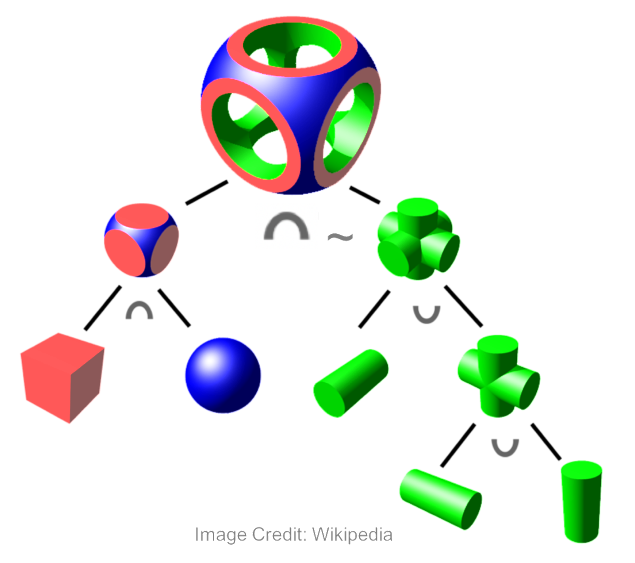

In [1]:
using Images
load("./figures/Csg_tree.png")

Usage of CSG can be very efficient compared to other methods as only a handful of primitive shapes need to be defined in order to create very complex geometry. This is efficient from a development standpoint, as attempting to come up with a single equation to define the complex shape above would be very difficult. CSG is also efficient compared to unstructured meshing for some purposes, as accurately resolving the above complex shape might require hundreds or thousands of mesh surfaces to define. However, it is important to note that CSG is not always appropriate for all cases, as some physics do not work well with CSG (such as where the geometry may deform, or where the scientific equations require a cartesian grid, or where equations do not work easily on second order surfaces).

### 1.2 - What is Ray Tracing?

Many computational methods also perform ray tracing, wherein a virtual ray (having an origin point and a direction) is followed through a CSG geometry to determine where its next intersection point is. In the context of the package developer's field of research, nuclear reactor simulation, CSG and ray tracing are used by the Method of Characteristics, Monte Carlo particle transport, and Collision Probability Method simulation techniques. However, CSG and ray tracing are used by a variety of fields including Characteristic methods in astrophysics and computer generated imaging for animated media. 

### 1. 3 - Why a new package?

In my field of nuclear engineering, development of most new simulation codes or prototyping a new simulation method often involves coding an entire CSG and ray tracing library from scratch. This has become particularly a problem in several Nuclear Engineering classes at MIT, where new students and researchers must create a large amount of their own CSG and ray tracing code before any physics or research gets done. In the classes 22.211 and 22.212 for instance, problem sets involve students each coding their own neutron transport solvers, building them up from the beginning of the semester and progressively adding more physics for each assignment. In the past, students have spent weeks coding up and fixing bugs in their geometry before any physics is done. This package is meant to allow students and researchers to focus on physics rather than geometry.

While there are a number of existing libraries in other languages for handling CSG and ray tracing, they are usually graphics oriented, and surprisingly do not always provide certain types of functionality that a scientific simulation requires. They also are usually very heavyweight, with a lot of parameters to describe the many different surface properties and scattering types that are required for graphics operations. For instance, graphics CSG and ray tracing packages place an emphasis on the features (color, albedo, texture, etc) of surfaces, but often assume that the spatial medium itself is of little interest. In nuclear simulation on the other hand, we care very little about the properties of the surfaces but care a great deal about the particular material the ray is passing through, which can be difficult to determine in many existing CSG and ray tracing packages. Graphics based CSG packages are also often very difficult to understand without having taken a class in graphics programming, due to the domain specific jargon such as "scene", "camera", "shader", etc. The net result is that existing packages in other languages are often either difficult to use for scientific programmers or simply not viable, resulting in many scientific programmers choosing to write their own CSG and ray tracing treatment from the ground up.

While I hope that this new package may be useful for a wide variety of computational fields, I have only focused on providing the features required for nuclear reactor simulations (Method of Characteristics, Monte Carlo, and Collision Probability Method) as that is my particular expertise and knowledge domain.

## 2 - Constructive Solid Geometry Concepts

### 2.1 - CSG Primitives

Constructive Solid Geometry techniques work well with any surface that can be defined by an arbitrary order equation. This package however is currently limited to four different types of second order surfaces: **Spheres**, **Planes**, **Cones**, and **Infinite Cylinders**. This package uses the general form of these surfaces, rather than specific versions aligned to a particular axis. In practice, these four second order surfaces can be used to construct very complex geometry, and are often all that is required for nuclear simulations. In the future, more primitives such as ellipsoids may be added.

### 2.2 - CSG Halfspaces

Any CSG surface can be said to divide all of 3D cartesian space into two halves -- a positive half and a negative half. These spaces are defined by whether the equation of the surface given a point in space is positive or negative. In this section, the halfspace functions for each of the four primitives in this package are defined. The key takeaway from this section from a user standpoint is to understand which sign corresponds to which halfspace for each surface type.

#### Sphere

For example, take the equation for a sphere:

$(x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2 = R^2$

Then move all the terms to one side and define a new function to determine the sign of the halfspace:

$f(x, y, z) = (x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2 - R^2$

The halfspace inside the sphere is ***-***, outside the sphere is ***+***.

#### 3D Plane

For other surfaces, such as an arbitrary 3D plane, we can follow the same process. In the case of the plane, the halfspace is defined as -1 for points below the normal direction of the plane, and +1 with points above the normal direction of the plane. We find the halfspace equation for an arbitrary 3D Plane, given its surface equation:

$Ax + By + Cz = D$

of in terms of a point $P$:

$N \cdot P = N \cdot C$

where:

$N$ is the plane's normal

$P$ is the point we are testing

$C$ is a point on the plane

This gives us the equation:

$f(P) = N \cdot P - N \cdot C$

It is important to note that a plane may have two valid unit normals that are opposites of each other, but will affect the sign of the halfspace. Keep in mind that the (***+***) side of a plane's halfspace is on the side the normal points to.

#### Arbitrary Cone

We can find the halfspace of an arbitrary cone by taking its equation:

$[(P - C) \cdot V]^2 - (P - C) \cdot (P - C) \cos^2(\theta) = 0$

Where:

$P$ is the the point in question $\{x, y, z\}$

$C$ is the point at the tip of the cone

$V$ is the unit direction representing the axis of the cone. As the cone equation actually defines two cones eminating in a mirrored fashion from the tip, this direction vector also indicates which cone is the "true" cone, i.e., following the direction of the axis $V$ when starting from $C$ should lead into the cone we actually want.

$\theta$ is the angle between the axis $V$ and the surface of the cone (between 0 and $\frac{\pi}{2}$)

This gives us a function for the halfspace of:

$f(P) = [(P - C) \cdot V]^2 - (P - C) \cdot (P - C) \cos^2(\theta)$

The halfspace inside the cone is ***+***, outside the cone is ***-***.

#### Arbitrary Infinite Cylinder

And finally, we can find the halfspace of an arbitrary infinite cylinder by taking its equation:

$[(P - O) \times D]^2 = R^2$

Where:

$P$ is the the point in question $\{x, y, z\}$

$O$ is a point at the center of the cylinder

$D$ is the unit direction of the cylinder (i.e., a point normal to an end cap for the cylinder)

$R$ is the radius of the cylinder

This gives us a function for the halfspace of:

$f(P) = [(P - O) \times D]^2 - R^2$

The halfspace inside the cylinder is ***-***, outside the cylinder is ***+***.

### 2.3 - Logical Cell

A set of CSG halfspaces can be combined using logical operators to define a bounded volume of space. Operators supported in this package are the intersection operator ^, the union operator |, and the complement operator ~. More information can be found in the "CSG Logical Operators" example, but a short example is shown below using logical operators to create a complex shape.

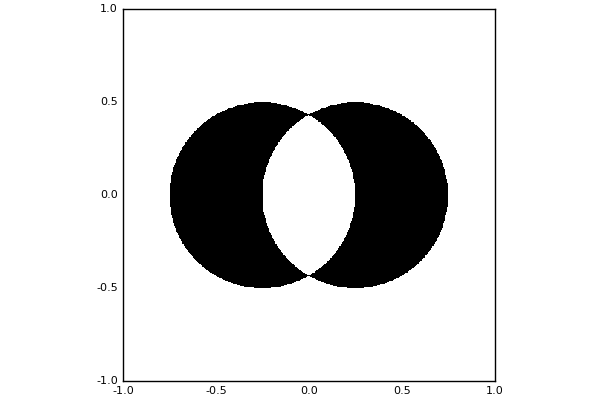

In [2]:
load("./figures/circle_cancel.png")

The plot above represents the cell (in black) of two circles defined by the following logical construction. The halfspace inside the circle on the left is "1", the halfspace inside the circle on the right is "2".

~(1 ^ 2) ^ (1 | 2)

### 2.4 - Boundary Conditions
In many simulations a variety of boundary conditions are used. This package supports reflective, vacuum, and transmission boundary conditions. Reflective boundaries reflect the ray when it contacts them. Transmission conditions (default) will simply let the ray pass through the boundary. Vacuum boundaries behave similarly to transmission, but are present so as to alert the user when a vacuum condition is encountered. This is done as the user may wish to terminate the ray, or enforce some other condition whenever a vacuum is encountered.

Currently, reflective boundary condtions can only be applied to the Plane surface type, though reflective conditions for more surfaces may be added in the future.

## 3 - Ray Tracing Concepts
Once a CSG geometry is established, many simulation techniques perform ray tracing within the geometry. One way to visualize this is for the case of Monte Carlo particle simulation. Here, a particle moves through the geometry of the problem, travelling between the different material regions and occasionally changing direction before being absorbed or escaping. While the physics will be determined by the application developer, this ray tracing package  provides an API for the developer to keep track of the particle's location as it travels through the geometry. A common task that the application developer will perform is to use the ray tracing package to determine what cell the particle is in and how far it will travel before exiting the cell. The ray tracer is also responsible for enforcing reflective boundary conditions and allowing the developer to know when a boundary is encountered.

Below is an image representing the random walk of a particle from the "Monte Carlo Particle Simulation" example problem.

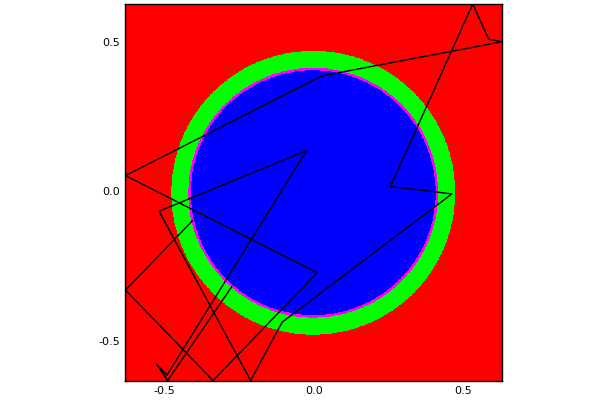

In [3]:
load("./figures/MC_example.png")

## 4 - Package Capabilities
ConstructiveSolidGeometry.jl aims to provide geometry and ray tracing functionality which aims to enable scientific application developers to focus on science rather than geometry. Therefore, the goal of the package is to provide a clean interface for application developers to create a geometric system, allow them to associate their simulation data with the underlying geometry, and to perform ray tracing operations. Below is a summary of capabilities of the package. There is of course signficantly more functionality that is hidden behind the public interface, but the below functionality are items that are of interest to a user.

### 4.1 - Geometry Building Functionality
* Allows users to define surfaces such as `Plane`, `Sphere`, `Cone`, and `InfCylinder`.
* Allows users to define various `Region` objects, which are the combination of a surface and a positive or negative halfspace.
* Allows users to logically combine `Region` objects in order to construct a bounded volume known as a `Cell`, by way of a Julia expression. Logical operators are intersection (`^`), union (`|`), and complement (`~`).
* Allows users to store an arbitrary number of `Cells` together into a top level `Geometry` object which can then be acted on by the ray tracing API.
* Offers basic plotting functionality to ensure that a full `Geometry` or a specific `Cell` look as expected. This is important as it is easy for users to make mistakes using logical operators, so plotting is critical to ensure that the geometry is correct.

### 4.2 - Ray Tracing 
* Allows users to create `Ray` objects, composed of an origin point and a direction vector.
* Allows users to generate a randomized `Ray` in 3D space and direction inside of a bounding box.
* Determine which cell a `Ray` object's origin is inside of. All cells in a `Geometry` have unique indices, so arbitray user data can be associated with each cell. This is an important aspect of the package that allows for a wide variety of different physics to be carried out using the API.
* Determine where the nearest intersection location is for a `Ray` inside of a full `Geometry`.
* Determine where the nearest intersection location is for a `Ray` given an array of `Region` objects. This is useful if an application developer is using an acceleration scheme (such as a lattice) to limit the number of surfaces that need to be checked for intersection.
* Allows users to reflect a `Ray` with a `Plane`. This is necessary for enforcing reflective boundary conditions.
* Track which boundary condition type is encountered at each intersection.
* Move a ray forward through its next intersection.

### 4.3 - Examples
Numerous examples are given in the examples directory, showcasing how to use the package to build a geoemetry, ray trace in it, and even how to create a straw man Monte Carlo particle transport application.